In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# load and prepare data

df_11_SSP1 = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/linear_SSP1_11_2040.csv')
df_11_SSP1_test = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/linear_SSP1_11_2050.csv')
df_11_SSP1_cubic = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/cubic_SSP1_11_2040.csv')
df_11_SSP1_cubicroot = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/linear paths/cubicroot_SSP1_11_2040.csv')

df_11_SSP1_cubic.tail()

,USD,0,2,4,6,8,10,12,14,16,18,20,reduction
196,3920,0.0,3.92,31.36,105.84,250.88,490.0,846.72,1344.56,2007.04,2857.68,3920.0,58.7773
197,3940,0.0,3.94,31.52,106.38,252.16,492.5,851.04,1351.42,2017.28,2872.26,3940.0,58.7783
198,3960,0.0,3.96,31.68,106.92,253.44,495.0,855.36,1358.28,2027.52,2886.84,3960.0,58.7793
199,3980,0.0,3.98,31.84,107.46,254.72,497.5,859.68,1365.14,2037.76,2901.42,3980.0,58.7803
200,4000,0.0,4.00,32.00,108.00,256.00,500.0,864.00,1372.00,2048.00,2916.00,4000.0,58.7813


In [330]:
"""
This class will create a model which finds the reduction that comes with a certain 
carbon price path. 
"""

# model adhv kaj's input

class model:
    
    def __init__(self):
        
        self.lin_path = []
        self.lin_reduction = []
        
        self.random_path = []
        self.random_reduction = []
        
    def train(self, lin_path, lin_reduction, random_path, random_reduction,
             random_index):
        
        # check input
        
        """
        Here the weights for each ctax step is calculated
        
        Load values: linear paths and random paths including the reductions from TIMER
        output is b values for given ctax levels (weights)
        """
        
        # define paths and reduction from input
        
        # linear
        self.lin_path.append(lin_path)
        
        self.lin_path = np.asarray(self.lin_path)
                
        self.lin_reduction.append(lin_reduction)
        
        self.lin_reduction = np.asarray(self.lin_reduction)
        
        # random
        self.random_path.append(random_path)
        
        self.random_path = np.asarray(self.random_path)
                
        self.random_reduction.append(random_reduction)
        
        self.random_reduction = np.asarray(self.random_reduction)
        
        # make dataframes
        df_combined_lin = pd.concat([lin_path.reset_index(drop=True),
                                 lin_reduction.reset_index(drop=True)], axis=1)
        
        df_combined_random = pd.concat([random_path.reset_index(drop=True),
                                 random_reduction.reset_index(drop=True)], axis=1)
        
        # find reduction levels for linear and random path at same ctax level @ random index
        
        # ctax and reduction of random path @ random index
        ctax_val_rand = self.random_path[0][random_index][-1]
        
        cur_red_rand = self.random_reduction[0][random_index]
        
        # get the linear reduction corresponding to the ctax level of random input
        last_column = df_combined.columns[-2]
        
        cur_red_lin = df_combined_lin.loc[df_combined_lin[last_column] == ctax_val_rand]
        
        cur_red_lin = cur_red_lin['reduction'].values[0]
        
        print(cur_red_lin, cur_red_rand)
        
        # calculate delta_C
        cur_rand_path = self.random_path[0][random_index]
        
        cur_lin_path =  self.lin_path[0][random_index]
        
        delta_c = cur_lin_path - cur_rand_path
        
        norm_delta_c = [i/cur_lin_path[-1] for i in delta_c]
        
        
        # find weigths b, by optimisation and save (array of weights with label ctax level)
        
#         def calc_diff(x, norm_delta_c):
            
#             for i in range(len(norm_delta_c)):
     
#                 calc_diff = sum(abs(cur_red_rand - 
#                                (cur_red_lin + 
#                                 sum(x[i] * norm_delta_c[i]))))
        
#             return calc_diff
        
        # define objective function
        def objective(x, norm_delta_c, cur_red_lin, cur_red_rand):
            
            calc_diff = abs(cur_red_rand - cur_red_lin + x.dot(norm_delta_c)) 
            
            return calc_diff
        
        # define objective function with multiple input paths --- snap niet precies hoe dit werkt
        def objective2(x, norm_delta_c, cur_red_lin, cur_red_rand):
            
            calc_diff = []
            
            for i in range(len(cur_red_rand)):
            
                calc_diff[i] = abs(cur_red_rand[i] - cur_red_lin + x[i].dot(norm_delta_c[i])) 
            
            return calc_diff
        
        # set initial values to 0
        x0 = [i*0 for i in norm_delta_c]  
                
        # minimize objective function
        res = minimize(objective, x0, args=(norm_delta_c, cur_red_lin, cur_red_rand),
                      method='Nelder-Mead')
        
        # print results
        print(res)
        
        # save weights to ctax level
        [weights, ctax] = [res.x, ctax_val_rand]
        
        # return dataframe with weights and ctax label
            
    def run(self, random_path, df):
        
        """
        here we use the calculated weights to determine the reduction for a
        random chosen path
        """
        


# check if model works
paths_linear = df_11_SSP1.drop(['USD','reduction'], axis = 1)
reduction_linear = df_11_SSP1['reduction']

paths_cubic = df_11_SSP1_cubic.drop(['USD','reduction'], axis = 1)
reduction_cubic = df_11_SSP1_cubic['reduction']

paths_cubicroot = df_11_SSP1_cubicroot.drop(['USD','reduction'], axis = 1)
reduction_cubicroot = df_11_SSP1_cubicroot['reduction']

x = model()

random_index = np.random.randint(0, 200)

df_combined = x.train(paths_linear, reduction_linear, paths_cubic, reduction_cubic,
                     random_index)

# x.run(random_path, df_combined)

# fig, ax = plt.subplots()

# print('random path: ',random_path)

# ax.scatter([x.nearest1, x.nearest2], [x.reduction1, x.reduction2])
# ax.scatter(x.key_val, x.reduction, color = 'red')
# ax.plot([x.nearest1, x.nearest2], [x.reduction1, x.reduction2], '--')

# ax.set_xlabel('price')
# ax.set_ylabel('reduction')

# x.reduction

19.6691 20.6578
 final_simplex: (array([[ 0.75591895,  0.72510224,  0.26921808,  0.88572486, -1.03410085,
        -0.45823394, -1.8515402 , -0.23718531,  0.28020285, -0.69998572,
         1.06697749],
       [ 0.75591782,  0.72510138,  0.26921786,  0.88572383, -1.03409946,
        -0.45823342, -1.8515378 , -0.23718496,  0.2802025 , -0.69998521,
         1.06697618],
       [ 0.75594541,  0.72512792,  0.26922782,  0.88575733, -1.03413671,
        -0.45824996, -1.85160682, -0.2371937 ,  0.28021287, -0.70001314,
         1.06701546],
       [ 0.75591702,  0.72509978,  0.26921745,  0.88572322, -1.03409802,
        -0.45823225, -1.85153528, -0.23718439,  0.28020219, -0.6999843 ,
         1.06697288],
       [ 0.75594654,  0.72512909,  0.26922806,  0.88575777, -1.03413939,
        -0.45825095, -1.85160774, -0.23719412,  0.28021306, -0.70001224,
         1.06701693],
       [ 0.75591573,  0.72509817,  0.26921663,  0.88572142, -1.03409675,
        -0.45823148, -1.85153082, -0.2371839 ,  0.2802

0         0.0
1        20.0
2        40.0
3        60.0
4        80.0
        ...  
196    3920.0
197    3940.0
198    3960.0
199    3980.0
200    4000.0
Name: 20, Length: 201, dtype: float64
[[3820.0], [3840.0], [3860.0], [3880.0], [3900.0], [3920.0], [3940.0], [3960.0], [3980.0], [4000.0]]
Coefficients: 
 [0.01236331]
Mean squared error: 50.03
Coefficient of determination: 0.80


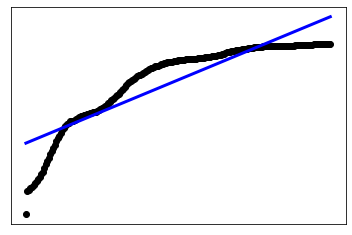

In [64]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

costs = df_11_SSP1['20']
reduction = df_11_SSP1['reduction'].values

print(costs)

# Use only one feature
# costs = costs[:, np.newaxis, 2]

costs_list = []

for cost in costs:
    costs_list.append([cost])
    
costs = costs_list

print(costs[-10:])

# Split the data into training/testing sets, kan niet want pad loopt omhoog
costs_train = costs
costs_test = costs

# Split the targets into training/testing sets
reduction_train = reduction
reduction_test = reduction

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(costs_train, reduction_train)

# Make predictions using the testing set
reduction_pred = regr.predict(costs_test)

# print(reduction_test - reduction_pred)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(reduction_test, reduction_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(reduction_test, reduction_pred))

# Plot outputs
plt.scatter(costs_test, reduction_test,  color='black')
plt.plot(costs_test, reduction_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

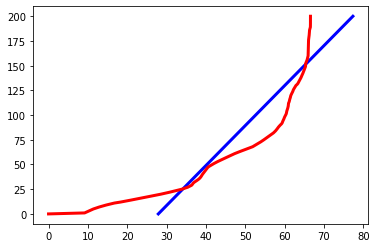

In [102]:
"""
Linear regression using sklearn, here we try to find the linear fit corresponding to the costcurve.
"""

X = df_11_SSP1.drop('reduction', axis=1)
y = df_11_SSP1['reduction']

X_test = df_11_SSP1_test.drop('reduction', axis=1)
y_test = df_11_SSP1_test['reduction']

linear_regression = linear_model.LinearRegression()

linear_regression.fit(X,y)

y_pred = linear_regression.predict(X)

x_axes = df_11_SSP1.index.values

plt.plot(y_pred, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)


0.804469469607436


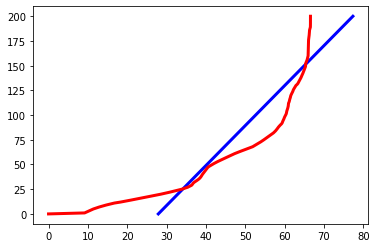

In [89]:
# Ridge regression

"""
Ridge regression addresses some of the problems of Ordinary Least Squares by imposing
a penalty on the size of the coefficients. The ridge coefficients minimize a penalized 
residual sum of squares
"""

ridge_reg = linear_model.Ridge(alpha=.5)

ridge_reg.fit(X,y)

y_pred_ridge = ridge_reg.predict(X)

plt.plot(y_pred_ridge, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = ridge_reg.score(X,y)

print(score)

0.03853142926464648


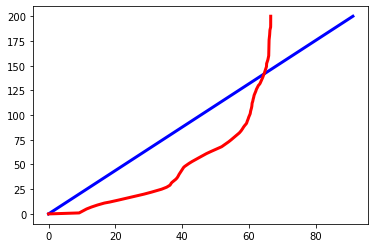

In [101]:
# Kernel ridge

"""
combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick.
It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels,
this corresponds to a non-linear function in the original space.
"""

from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=1.0)
clf.fit(X, y)

y_pred_clf = clf.predict(X_test)

plt.plot(y_pred_clf, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = clf.score(X,y)

print(score)

0.8832715065513569


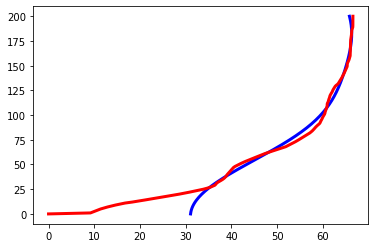

In [108]:
# Support Vector Machine

from sklearn import svm

svm_reg = svm.SVR()

svm_reg.fit(X,y)

y_pred_SVM = svm_reg.predict(X)

plt.plot(y_pred_SVM, x_axes, color='blue', linewidth=3)
plt.plot(y, x_axes, color='red',linewidth=3)

score = svm_reg.score(X,y)

print(score)

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


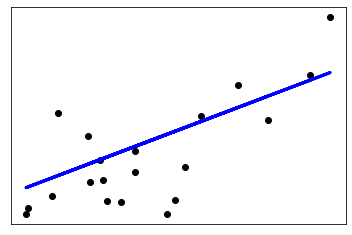

In [14]:
## Voorbeeld

# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

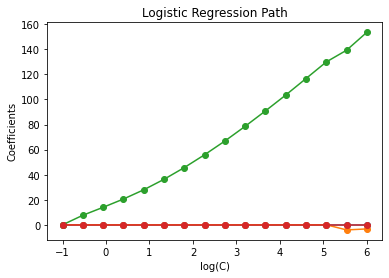

In [26]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

iris = datasets.load_iris()
X = iris.data # dit zou dan de paden van de reductie kunnen zijn
y = iris.target 

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()